## Installing all the necessary Packages

In [1]:
!pip install --upgrade pip

In [2]:
# First upgrade the environment.
from subprocess import run
# Add & Upgrade whatever you will need
modules =[
    #'yfinance',    # Required for Yahoo Finance model
    'fredapi',     # Required to access FRED Data for MacroEconomics indices
    'ta'           # Required for the MACD indicator
]
proc = run(f'pip install {" ".join(modules)} --upgrade --no-input', 
       shell=True, 
       text=True, 
       capture_output=True, 
       timeout=120) #a couple of minutes
print(proc.stderr)

In [3]:
# Text Formating {Fore Colors and Background Colors definition}
RESET = '\033[0m'
BOLD  = '\033[1m'
ITALIC= '\033[3m'
ULINE = '\033[4m'
BLINK = '\033[5m'
NEGATIVE = '\033[7m'

RED   = '\033[31m'
GREEN = '\033[32m'
YELLOW= '\033[33m'
BLUE  = '\033[34m'
PURPLE= '\033[35m'
CYAN  = '\033[36m'
WHITE = '\033[97m'

BgGREEN = '\033[42m'
BgYELLOW= '\033[43m'
BgBLUE  = '\033[44m'
BgWHITE = '\033[47m'

## Import All the General and commonly used Packages

In [4]:
# Import all the common modules
import os
import warnings
import requests
import numpy as np
import pandas as pd
from fredapi import Fred
from ta.trend import MACD
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Defining the reqired funtions

In [5]:
# Calculate Relative Strength Index (RSI)
def Calculate_RSI(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [6]:
# Calculate Exponential Moving Average (EMA)
def Calculate_EMA(data, n):
    ema_values = [data[0]]  # Initialize EMA list with the first value
    smoothing_factor = 2 / (n + 1)
    
    for i in range(1, len(data)):
        ema = (data[i] * smoothing_factor) + (ema_values[i - 1] * (1 - smoothing_factor))
        ema_values.append(ema)
    
    return ema_values

In [7]:
def FillGaps(StartingDate, EndingDate, StartVal, EndVal):
    import math
    
    # Generate business days for the year
    Business_Days = pd.date_range(start=StartingDate+timedelta(days=1, hours=0), end=EndingDate-timedelta(days=1, hours=0), freq='B')

    # Calculate the incremental value
    SVal = value = float(StartVal)
    EVal = value = float(EndVal)
    if (math.isnan(SVal)):
        Incremental_Value = 0
    elif ((not math.isnan(SVal)) & (math.isnan(EVal))):
        Incremental_Value = StartVal
    elif ((not math.isnan(SVal)) & (not math.isnan(EVal))):
        Incremental_Value = (EndVal - StartVal) / (len(Business_Days) + 1)
    return Incremental_Value

In [8]:
# Function to fetch series from FRED
# This applies Calibration approach in flling the missing values
def Fetch_FRED_Calibrate(APIKey, CnrtyCode, IndName, Series_ID):
    StartDate = HistoryDataMinDate
    EndDate = pd.Timestamp.today().normalize()
    Data_Dict = {}
    try:
        Data = APIKey.get_series(Series_ID, StartDate, EndDate)
        Data_Dict[f'{CnrtyCode}_{IndName}'] = Data
        Df = pd.DataFrame(Data_Dict)
        Df.reset_index(inplace=True)
        Df.rename(columns={'index': 'Date'}, inplace=True)
        Df.sort_values(by=['Date'], ascending=[True], inplace=True)
        Df.fillna(0, inplace=True)
        MaxDate = Df.Date.max()
        DfRaw = Df.copy()
        for row in range(0, len(Df)-1):
            StartDate = DfRaw.iloc[row, 0]
            StartVal = DfRaw.iloc[row, 1]
            EndDate = DfRaw.iloc[row+1, 0]
            EndVal = DfRaw.iloc[row+1, 1]
    
            IncVal = FillGaps(StartDate, EndDate, StartVal, EndVal)
            Business_Days = pd.date_range(start=StartDate+timedelta(days=1, hours=0), end=EndDate-timedelta(days=1, hours=0), freq='B')
            Val = StartVal
            for BDay in Business_Days:
                Val = Val + IncVal
                Df.loc[len(Df.index)] = [BDay, Val]
    
        if (MaxDate < pd.Timestamp.today().normalize()):
            StartDate = MaxDate
            EndDate = pd.Timestamp.today().normalize()
            Business_Days = pd.date_range(start=StartDate+timedelta(days=1, hours=0), end=EndDate-timedelta(days=0, hours=0), freq='B')
            Val = EndVal
            for BDay in Business_Days:
                Val = Val + IncVal
                Df.loc[len(Df.index)] = [BDay, Val]
        return DfRaw, Df
    except Exception as e:
        print(f"Error fetching {CnrtyCode}_{IndName}: {e}")
        return None

In [9]:
# Function to fetch MacroEconomics data from FRED
# This applies the approach of flling the missing values with the Last known value.
def Fetch_FRED_LastKnown(APIKey, CnrtyCode, IndName, Series_ID):
    StartDate = HistoryDataMinDate
    EndDate = pd.Timestamp.today().normalize()
    Data_Dict = {}
    try:
        Data = APIKey.get_series(Series_ID, StartDate, EndDate)
        Data_Dict[f'{CnrtyCode}_{IndName}'] = Data
        Df = pd.DataFrame(Data_Dict)
        Df.reset_index(inplace=True)
        Df.rename(columns={'index': 'Date'}, inplace=True)
        Df.sort_values(by=['Date'], ascending=[True], inplace=True)
        Df.fillna(0, inplace=True)
        MaxDate = Df.Date.max()
        DfRaw = Df.copy()
        for row in range(0, len(Df)-1):
            StartDate = DfRaw.iloc[row, 0]
            StartVal = DfRaw.iloc[row, 1]
            EndDate = DfRaw.iloc[row+1, 0]
            EndVal = DfRaw.iloc[row+1, 1]
    
            FillVal = 0
            if (StartVal != 0):
                FillVal = StartVal
            elif (EndVal != 0):
                FillVal = EndVal
            else:
                FillVal = 0
            Business_Days = pd.date_range(start=StartDate+timedelta(days=1, hours=0), end=EndDate-timedelta(days=1, hours=0), freq='B')
            for BDay in Business_Days:
                Df.loc[len(Df.index)] = [BDay, FillVal]
    
        if (MaxDate < pd.Timestamp.today().normalize()):
            StartDate = MaxDate
            EndDate = pd.Timestamp.today().normalize()
            Business_Days = pd.date_range(start=StartDate+timedelta(days=1, hours=0), end=EndDate-timedelta(days=0, hours=0), freq='B')
            for BDay in Business_Days:
                Df.loc[len(Df.index)] = [BDay, FillVal]
        return DfRaw, Df
    except Exception as e:
        print(f"Error fetching {CnrtyCode}_{IndName}: {e}")
        return None

In [10]:
# Function to fetch MacroEconomics data from World Bank
# This applies the approach of flling the missing values with the Last known value.
def Fetch_WorldBank(CnrtyCode, IndName, Series_ID):
    url = 'http://api.worldbank.org/v2/country/' + CnrtyCode + '/indicator/' + Series_ID
    #StartDate = HistoryDataMinDate
    #StartYear = StartDate.strftime('%Y')
    StartYear = '1982'
    # Retrieve current Year
    CurrYr = pd.Timestamp.today().strftime('%Y')
    
    # Parameters to specify the data format and time range
    params = {
        'format': 'json',
        'date': StartYear + ':' + CurrYr,  # specify the time range you're interested in
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()[1]  # extract the actual data from the response
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        Df = df[['date', 'value']]
        Df.rename(columns={"date": "Date", "value": f'{CnrtyCode}_{IndName}'}, inplace=True) 
        Df.sort_values(by=['Date'], ascending=[True], inplace=True)
        Df.fillna(0, inplace=True)
        MaxDate = Df.Date.max()
        DfRaw = Df.copy()
        for row in range(0, len(Df)-1):
            StartDate = DfRaw.iloc[row, 0]
            StartVal = DfRaw.iloc[row, 1]
            EndDate = DfRaw.iloc[row+1, 0]
            EndVal = DfRaw.iloc[row+1, 1]
    
            FillVal = 0
            if (StartVal != 0):
                FillVal = StartVal
            elif (EndVal != 0):
                FillVal = EndVal
            else:
                FillVal = 0
            Business_Days = pd.date_range(start=StartDate+timedelta(days=1, hours=0), end=EndDate-timedelta(days=1, hours=0), freq='B')
            for BDay in Business_Days:
                Df.loc[len(Df.index)] = [BDay, FillVal]
    
        if (MaxDate < pd.Timestamp.today().normalize()):
            StartDate = MaxDate
            EndDate = pd.Timestamp.today().normalize()
            Business_Days = pd.date_range(start=StartDate+timedelta(days=1, hours=0), end=EndDate-timedelta(days=0, hours=0), freq='B')
            for BDay in Business_Days:
                Df.loc[len(Df.index)] = [BDay, FillVal]

        return DfRaw, Df
    except Exception as e:
        print(f"Error fetching {CnrtyCode}_{IndName}: {e}")
        return None

In [11]:
# Checking how good this Model will be
# This function compares the R² value from both the Train and Test data, and makes its Comment. Its Comment is used in this algorithm for taking many other decisions.
def TestTheModel(Model):
    y_Train_Pred = Model.predict(X_train)
    y_Test_Pred = Model.predict(X_test)
    
    r2_Train = 0.00
    r2_Test = 0.00
    # Calculate R² error on Training Data and Test Data
    r2_Train = r2_score(y_train, y_Train_Pred)
    r2_Test = r2_score(y_test, y_Test_Pred)
    
    # Display results
    print(f"R² error on Training Data: {r2_Train:.5f}")
    print(f"R² error on Test Data: {r2_Test:.5f}")
    
    # Confirm that R² error on Training Data is better than R² error on Test Data
    if (r2_Train >= r2_Test) & ((1.00 - r2_Train) < 0.1) & ((r2_Train - r2_Test) < 0.1):
        if (r2_Test == 1.00):
            Comment = 'Overfitted Model!'
            print(f'{BOLD+GREEN+BgWHITE}{Comment}{RESET}\n{BOLD+ITALIC+NEGATIVE+BgGREEN}R² error on Training Data equals R² error on Test Data.{RESET}')
        elif (r2_Train > r2_Test) & ((1.00 - r2_Train) < 0.0001) & ((r2_Train - r2_Test) < 0.001):
            Comment = 'Excellent Model!'
            print(f'{BOLD+GREEN+BgWHITE}{Comment}{RESET}\n{BOLD+ITALIC+NEGATIVE+BgGREEN}R² error on Training Data is better than R² error on Test Data.{RESET}')
        elif (r2_Train > r2_Test) & ((1.00 - r2_Train) < 0.001) & ((r2_Train - r2_Test) < 0.01):
            Comment = 'Very Good Model!'
            print(f'{BOLD+GREEN+BgWHITE}{Comment}{RESET}\n{BOLD+ITALIC+NEGATIVE+BgGREEN}R² error on Training Data is better than R² error on Test Data.{RESET}')
        #elif (r2_Train >= r2_Test) & ((1.00 - r2_Train) < 0.5) & ((1.00 - r2_Test) <= 0.5):
        else:
            Comment = 'Good Model.'
            print(f'{BOLD+BLUE+BgWHITE}{Comment}{RESET}\n{BOLD+ITALIC+NEGATIVE+BgBLUE}R² error on Training Data is better than R² error on Test Data.{RESET}')
    elif ((r2_Train <= 0.0000) | (r2_Test <= 0.1)):
        Comment = 'Very Bad Model.'
        print(f'{BOLD+RED+BLINK+BgYELLOW}{Comment}{RESET}')
    else:
        Comment = 'Bad Model.'
        print(f'{BOLD+RED+BLINK+BgYELLOW}{Comment}{RESET}')
    return r2_Train, r2_Test, Comment

In [12]:
# This function, after Spliting only Plots the Train and Test prices.
# It displays the raw data as it was from the Source.
def Plot_TrainTest(CrncyPair, Y_Train, Y_Test):
    plt.figure(figsize=(14, 6))
    plt.plot(Y_Train.index, Y_Train.values, label='Training Data', color='blue')
    plt.plot(Y_Test.index, Y_Test.values, label='Test Data', color='orange')
    plt.title('The Train/Test data for ' + CrncyPair + ' Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

In [13]:
# This function, after Spliting only Plots the Train and Test prices.
# It displays the raw data as it was from the Source.
def Plot_RawMacroEcons(Source, MacroEconomic_Series, CrncyPair, Y_Train, Y_Test, RawMacroEcons):
    plt.figure(figsize=(14, 6))
    for IndName, Series_ID in MacroEconomic_Series.items():
        plt.scatter(RawMacroEcons['Date'], RawMacroEcons[f'USA_{IndName}'].values, s=10, label=f'USA_{IndName}', color='red')
        plt.scatter(RawMacroEcons['Date'], RawMacroEcons[f'CAN_{IndName}'].values, s=10, label=f'CAN_{IndName}', color='green')
        plt.figure(figsize=(14, 6))
        plt.plot(Y_Train.index, Y_Train.values, label='Training Data', color='blue')
        plt.plot(Y_Test.index, Y_Test.values, label='Test Data', color='orange')
        plt.title('The Train/Test data with Raw ' + f'{IndName} from {Source}')
        plt.xlabel('Date')
        plt.ylabel('Closing Price')

    plt.legend()
    plt.show()

In [14]:
# For each of the models, this function plots the Actual values agaist the Predicted valus for easy evaluation of the model.
def Rpt_Evaluate_Plot(CrncyPair, Model_Name, Model_Code, R2_Train, R2_Test, Comment, Y_Train, Y_Test, Y_Pred, MaxDate, Future_Preds):
    # Evaluate the model
    mae = mean_absolute_error(Y_Test, Y_Pred)
    print("Mean Absolute Error: {:.5f}".format(mae))
    # ============================================
    mse = mean_squared_error(Y_Test, Y_Pred)
    print("Mean Squared Error: {:.5f}".format(mse))
    # ===================================================
    rmse = np.sqrt(mse)
    print('Root Mean Squared Error: {:.5f}'.format(rmse))
    # ============================================
    r2 = r2_score(Y_Test, Y_Pred)
    print("R-squared (R2) score: {:.5f}".format(r2))
    # ============================================
    print('Future Predictions', Future_Preds)

    # Get the Future Dates
    Future_Dates = pd.date_range(start=MaxDate+timedelta(days=1), periods=len(Future_Preds), freq="B")

    # Plot Actual vs Predicted prices
    plt.figure(figsize=(14, 6))
    plt.plot(Future_Dates, ActualValues, label='Actual Data', color='green')
    plt.plot(Future_Dates, Future_Preds, label='Predicted Data', color='blue')
    plt.scatter(Future_Dates, ActualValues, s=10, color='red')
    plt.scatter(Future_Dates, Future_Preds, s=10, color='red')
    plt.title(Model_Name + ': Actual vs Predicted values for ' + CrncyPair + ' Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

    # Inserting Record into the DataFrame
    Models_Compare.loc[len(Models_Compare.index)] = [Model_Name, Model_Code, mae, mse, rmse, R2_Train, R2_Test, Comment]

## Load the Currency Pair into DataFrame

In [15]:
TDSData = []
Investing = []

# Suppress all warnings
warnings.filterwarnings("ignore")

# Today's Date
TDate = pd.Timestamp.today().normalize()

In [16]:
# Every Currency Pair is a combination of Major and Minor currency
CrncyPair = 'USDCAD'
Major = CrncyPair[0:3]
Minor = CrncyPair[3:]

In [17]:
%%time
# My GitHub Data path
MyGitHubURL = 'https://raw.githubusercontent.com/Akubue4U/PyProjects/main/MyBDAThesis/'

# DATA SOURCE 01 (Investing Data stored in GitHub)
# ================================================
# Reading data from csv file, which was uploaded to GitHub.
# Data was downloaded from the link below, and saved as .csv
# https://www.investing.com/currencies/usd-cad-historical-data
DataFolder = 'InvestingData/'
Base_URL = MyGitHubURL + DataFolder
InvCrncyPair = Major +'_'+ Minor
InvFileName = InvCrncyPair + '_Historical_Data'

# Check if the URL exists and is accessible
SuccessCode = [200, 400]
response = requests.head(Base_URL, timeout=5)
try:
    #if response.status_code in SuccessCode:
    File_URL = f'{Base_URL}{InvFileName}.csv'
    InvestingData = pd.read_csv(File_URL)
    InvestingData.drop(InvestingData.columns[[6]], axis=1, inplace=True)
    InvestingData['Vol.'] = InvestingData['Vol.'].fillna(0)

    # Convert Date string column to Date type
    InvestingData['Date'] = pd.to_datetime(InvestingData['Date'], format='%m/%d/%Y')

    # Set column 'Date' as the index
    InvestingData.set_index('Date', inplace=True)

    # Re-Arrange the columns to allign with that from Source 02 below.
    # Using indexing notation
    InvestingData = InvestingData[['Open', 'High', 'Low', 'Price', 'Vol.']]
    InvestingData.rename(columns={"Vol.": "Volume"}, inplace=True)
    
    # Some of the data is formated in Thousands, thus having Commas.
    # Remove commas and convert to float for specific columns
    for Col in ['Price', 'Open', 'High', 'Low', 'Volume']:
        if pd.api.types.is_object_dtype(InvestingData[Col]):
            InvestingData[Col] = InvestingData[Col].str.replace(',', '').astype(float)

    # Also sort the Data by Dates to allign with Source 02 below.
    InvestingData.sort_values(by=['Date'], ascending=[True], inplace=True)
    DataSource = InvestingData.copy()
    
    # Filter rows where Date is >= '04-Aug-2003'
    # I only activated this to compare the similarity of this (Investing.Com) Data source with that of TDS below.
    # Remember, Tick Data Suite (TDS) history data started from 04-Aug-2003.
    #DataSource = DataSource[(DataSource['Date'] >= '2003-08-04')]

    print("Data Source in use is Investing.Com")
except Exception as e:
    #print(f"Error accessing GitHub path [{Base_URL}]: \n{e}")
    # DATA SOURCE 02 (Tick Data Suite (TDS) stored in GitHub)
    # ======================================================
    # Reading data frame from csv file
    DataFolder = 'TDS-Data/'
    Base_URL = MyGitHubURL + DataFolder
    Symbol = Major + Minor +'_'

    # Check if the URL exists and is accessible
    response = requests.head(Base_URL, timeout=5)
    try:
        #if response.status_code in SuccessCode:
        # List to store DataFrames
        Df_List = []

        # Reading over 7,903,117 M1 data from GitHub
        # Iterate through the years and read each .csv file into a DataFrame
        for Year in range(2003, 2025):
            File_URL = f'{Base_URL}{Symbol}{Year}.csv'
            Df = pd.read_csv(File_URL)

            Df_List.append(Df)

        # Concatenate all DataFrames into one
        CombinedDf = pd.concat(Df_List, ignore_index=True)
        # Merge Date string and Time string, and convert to DateTime type
        CombinedDf['DateTime'] = pd.to_datetime((CombinedDf['Date'] + " " + CombinedDf['Time']), format='%Y.%m.%d %H:%M:%S')
        CombinedDf.drop(columns={'Date', 'Time'}, inplace=True)    
        CombinedDf.set_index(CombinedDf['DateTime'], inplace=True)

        # Stage 02
        # Subsample data to one-day time steps, including weekends
        DataOpen = CombinedDf.Open.resample('1D').first()
        DataHigh = CombinedDf.High.resample('1D').max()
        DataLow = CombinedDf.Low.resample('1D').min()
        DataClose = CombinedDf.Close.resample('1D').last()
        DataVolume = round(CombinedDf.TickVol.resample('1D').sum(), 2)

        # Merge the Data on a common key, Date
        TDSData = pd.merge(DataOpen, DataHigh, how='left', on=['DateTime'])
        TDSData = pd.merge(TDSData, DataLow, how='left', on=['DateTime'])
        TDSData = pd.merge(TDSData, DataClose, how='left', on=['DateTime'])
        TDSData = pd.merge(TDSData, DataVolume, how='left', on=['DateTime'])

        # Rename the index column to Date
        TDSData.reset_index(inplace=True)
        TDSData.rename(columns={'DateTime': 'Date', 'Close': 'Price', 'TickVol': 'Volume'}, inplace=True)
        TDSData.set_index('Date', inplace=True)
        TDSData.dropna(inplace = True)

        # Also sort the Data by Dates to allign with Source 01 above.
        TDSData.sort_values(by=['Date'], ascending=[True], inplace=True)
        DataSource = TDSData.copy()
        print("Data Source in use is TDS.")
    except Exception as e:
        print(f"Error accessing GitHub path [{Base_URL}]: \n{e}")
HistoryDataMinDate = DataSource.index.min()        

Data Source in use is Investing.Com
CPU times: user 75.1 ms, sys: 8.81 ms, total: 83.9 ms
Wall time: 730 ms


In [18]:
# Free the momory by deleting the DataFrames no longer needed
del TDSData
del Investing

In [19]:
DataSource

,Open,High,Low,Price,Volume
Date,,,,,
1982-01-05,1.1895,1.1895,1.1895,1.1895,0.0
1982-01-06,1.1863,1.1863,1.1863,1.1863,0.0
1982-01-07,1.1876,1.1876,1.1876,1.1876,0.0
1982-01-08,1.1863,1.1863,1.1863,1.1863,0.0
1982-01-11,1.1897,1.1897,1.1897,1.1897,0.0
...,...,...,...,...,...
2024-11-25,1.3973,1.4007,1.3925,1.3986,0.0
2024-11-26,1.3984,1.4177,1.3979,1.4052,0.0
2024-11-27,1.4052,1.4077,1.4007,1.4028,0.0


In [20]:
DataSource.describe()

,Open,High,Low,Price,Volume
count,11139.000000,11139.000000,11139.000000,11139.000000,11139.0
mean,1.272751,1.276642,1.268986,1.272741,0.0
std,0.147435,0.147352,0.147537,0.147433,0.0
min,0.920400,0.930700,0.905700,0.921700,0.0
25%,1.175700,1.179150,1.172350,1.175700,0.0
50%,1.292000,1.296400,1.287300,1.291800,0.0
75%,1.367000,1.369700,1.364000,1.366800,0.0
max,1.618800,1.619100,1.610700,1.614500,0.0


In [21]:
DataSource.tail(7).sort_values(by=['Date'], ascending=[False])

,Open,High,Low,Price,Volume
Date,,,,,
2024-11-29,1.4015,1.4045,1.3978,1.4002,0.0
2024-11-28,1.4029,1.4031,1.3996,1.4011,0.0
2024-11-27,1.4052,1.4077,1.4007,1.4028,0.0
2024-11-26,1.3984,1.4177,1.3979,1.4052,0.0
2024-11-25,1.3973,1.4007,1.3925,1.3986,0.0
2024-11-22,1.3968,1.4020,1.3955,1.3980,0.0
2024-11-21,1.3975,1.3978,1.3928,1.3970,0.0


In [22]:
print(len(DataSource))

11139


#### Adding the Technical Data to the DataSource

In [23]:
# Feature Engineering: Calculate rolling averages, momentum indicators, etc.
DataSource['SMA_20'] = DataSource['Price'].rolling(window=20).mean()
DataSource['SMA_50'] = DataSource['Price'].rolling(window=50).mean()
DataSource['RSI'] = Calculate_RSI(DataSource['Price'], window=14)
DataSource['EMA_12'] = Calculate_EMA(DataSource['Price'], 12)
DataSource['EMA_26'] = Calculate_EMA(DataSource['Price'], 26)
DataSource['MACD'] = MACD(DataSource['Price']).macd()

DataSource.drop('Volume', axis=1, inplace=True)

# Drop rows with missing values
DataSource.dropna(inplace=True)

In [24]:
DataSource

,Open,High,Low,Price,SMA_20,SMA_50,RSI,EMA_12,EMA_26,MACD
Date,,,,,,,,,,
1982-03-17,1.2154,1.2154,1.2154,1.2154,1.218265,1.206876,41.436464,1.216222,1.214402,0.001820
1982-03-18,1.2154,1.2154,1.2154,1.2154,1.218305,1.207394,26.388889,1.216095,1.214476,0.001620
1982-03-19,1.2204,1.2204,1.2204,1.2204,1.218485,1.208076,38.650307,1.216758,1.214915,0.001843
1982-03-22,1.2203,1.2203,1.2203,1.2203,1.218680,1.208730,41.721854,1.217303,1.215314,0.001989
1982-03-23,1.2207,1.2207,1.2207,1.2207,1.218680,1.209418,43.046358,1.217825,1.215713,0.002113
...,...,...,...,...,...,...,...,...,...,...
2024-11-25,1.3973,1.4007,1.3925,1.3986,1.395075,1.377828,63.790186,1.397065,1.391479,0.005586
2024-11-26,1.3984,1.4177,1.3979,1.4052,1.395765,1.378738,60.516605,1.398317,1.392495,0.005821
2024-11-27,1.4052,1.4077,1.4007,1.4028,1.396390,1.379586,67.075665,1.399006,1.393259,0.005748


In [25]:
print(len(DataSource))

11090


#### Get the MacroEconomics Data

In [26]:
# My FRED API key
MyAPIKey = Fred(api_key='fb871b8abb01c472840cdd407ffd8dca')

# This is the list of Indices we want to retrieve for USA and Canada
MacroEconomic_Series_USA = {
    'CPIs': 'CPIAUCSL',  # Consumer Price Index (USA)
    'IntRates': 'FEDFUNDS',  # Federal Funds Rate (USA)
    'UnEmployRates': 'UNRATE',  # Unemployment Rate (USA)
    'Imports': 'IMP0004',  # Imports (USA)
    'Exports': 'EXP0004'  # Exports (USA)
}

MacroEconomic_Series_Canada = {
    'CPIs': 'CANCPIALLMINMEI',  # Consumer Price Index (Canada)
    'IntRates': 'IR3TIB01CAM156N',  # Interest Rate (Canada)
    'UnEmployRates': 'LRUNTTTTCAM156S',  # Unemployment Rate (Canada)
    'Imports': 'XTIMVA01CAM667S',  # Imports (Canada)
    'Exports': 'XTEXVA01CAM667S'  # Exports (Canada)
}

# This is the list of Indices we want to retrieve for USA and Canada
MacroEconomic_Series_WorldBank = {
    'CPIs': 'FP.CPI.TOTL',  # Consumer Price Index
    'IntRates': 'FR.INR.RINR',  # Federal Funds Rate
    'Inflations': 'FP.CPI.TOTL.ZG',  # Inflation
    'UnEmployRates': 'SL.UEM.TOTL.ZS',  # Unemployment Rate
    'Imports': 'NE.IMP.GNFS.CD',  # Imports
    'Exports': 'NE.EXP.GNFS.CD',  # Exports
    'Revenues': 'GC.REV.XGRT.GD.ZS',  # Revenues
    'GDPRatios': 'NY.GDP.MKTP.CD',  # GDP Ratios
    'GDPGrowths': 'NY.GDP.MKTP.KD.ZG'  # GDP Growths
}

In [27]:
%%time
# Get the MacroEconomics Data
# Fetch data for USA
USA_Data = []
USA_RawData = []
CnrtyCode = 'USA'
for IndName, Series_ID in MacroEconomic_Series_USA.items():
    RawData, FilledData = Fetch_FRED_LastKnown(MyAPIKey, CnrtyCode, IndName, Series_ID)
    #RawData, FilledData = Fetch_FRED_Calibrate(MyAPIKey, CnrtyCode, IndName, Series_ID)
    if (len(USA_Data) ==  0):
        USA_Data = FilledData.copy()
        USA_RawData = RawData.copy()
    else:
        USA_Data = pd.merge(USA_Data, FilledData, on='Date')
        USA_RawData = pd.merge(USA_RawData, RawData, on='Date')

# Fetch data for Canada
Canada_Data = []
Canada_RawData = []
CnrtyCode = 'CAN'
for IndName, Series_ID in MacroEconomic_Series_Canada.items():
    RawData, FilledData = Fetch_FRED_LastKnown(MyAPIKey, CnrtyCode, IndName, Series_ID)
    #RawData, FilledData = Fetch_FRED_Calibrate(MyAPIKey, CnrtyCode, IndName, Series_ID)
    if (len(Canada_Data) ==  0):
        Canada_Data = FilledData.copy()
        Canada_RawData = RawData.copy()
    else:
        Canada_Data = pd.merge(Canada_Data, FilledData, on='Date')
        Canada_RawData = pd.merge(Canada_RawData, RawData, on='Date')

# Merge the MacroEconomic datasets on a common key, such as Date
MacroEcons_FRED = pd.merge(USA_Data, Canada_Data, on='Date')
RawMacroEcons_FRED = pd.merge(USA_RawData, Canada_RawData, on='Date')


WorldBankData = []
WorldBankRawData = []
Countries = ['USA', 'CAN']
for Cnrty in Countries:
    for IndName, Series_ID in MacroEconomic_Series_WorldBank.items():
        RawData, FilledData = Fetch_WorldBank(Cnrty, IndName, Series_ID)
        if (len(WorldBankData) ==  0):
            WorldBankData = FilledData.copy()
            WorldBankRawData = RawData.copy()
        else:
            WorldBankData = pd.merge(WorldBankData, FilledData, on='Date')
            WorldBankRawData = pd.merge(WorldBankRawData, RawData, on='Date')

#WorldBankRawData.dropna(inplace=True)
#WorldBankRawData.fillna(0, inplace=True)
MacroEcons_WorldBank = WorldBankData.copy()
RawMacroEcons_WorldBank = WorldBankRawData.copy()
del WorldBankData, WorldBankRawData

# Free the memory.
#del USA_Data, Canada_Data

CPU times: user 3min 34s, sys: 262 ms, total: 3min 34s
Wall time: 3min 42s


In [28]:
print(len(MacroEcons_FRED))
print(len(RawMacroEcons_FRED))
print(len(MacroEcons_WorldBank))
print(len(RawMacroEcons_WorldBank))

9493
429
11210
42


In [29]:
#RawMacroEcons_WorldBank

In [30]:
#RawMacroEcons_FRED

In [31]:
Zero_CPI = MacroEcons_FRED[MacroEcons_FRED['USA_Imports'] == 0]
Zero_CPI.tail(7).sort_values(by=['Date'], ascending=[False])

,Date,USA_CPIs,USA_IntRates,USA_UnEmployRates,USA_Imports,USA_Exports,CAN_CPIs,CAN_IntRates,CAN_UnEmployRates,CAN_Imports,CAN_Exports


In [32]:
#Non_Zero_CPI = MacroEcons_FRED[MacroEcons_FRED['USA_CPIs'] != 0]
#Non_Zero_CPI.tail(7).sort_values(by=['Date'], ascending=[False])

#### Mering the MacroEconomics Data with the DataSource

In [33]:
%%time
# Merge the DataSource with the MacroEconomic dataset on a common key, such as Date
Complete_Data = pd.merge(DataSource, MacroEcons_FRED, how='left', on=['Date'])
#Complete_Data = pd.merge(DataSource, MacroEcons_WorldBank, how='left', on=['Date'])

# Set NaN to Zero, and column 'Date' as the index
Complete_Data.fillna(0, inplace=True)
Complete_Data.set_index('Date', inplace=True)

# To test how the Model will be when there is no MacroEconomic Data, activate the following line.
#Complete_Data = DataSource.copy()

# Free the memory.
#del DataSource, MacroEcons

CPU times: user 6.03 ms, sys: 3 ms, total: 9.03 ms
Wall time: 8.72 ms


In [34]:
len(Complete_Data)

11090

In [35]:
%%time
# This Data was downloaded as from 1982.
# There some numeric fields with Zeros at the begining due to lack of data.
# This Block will identify the Max date from the bottom(1982) where Zeros ended.
# After which, those recored with Zeros in any of the columns will be deleted.
for Col in range(0, len(Complete_Data.columns)-1):
    RowCnt = 0
    MinDate = Complete_Data.index.min()
    MaxDate = MinDate
    for Row in range(0, len(Complete_Data)-1):
        if (Complete_Data.iloc[Row, Col] != 0.00):
            if (RowCnt > 0):
                ColMaxDate = Complete_Data.index[(RowCnt - 1)]
                if (ColMaxDate > MaxDate):
                    MaxDate = ColMaxDate
            break
        RowCnt += 1

# Delete out rows with Date in the specified range
Complete_Data = Complete_Data[~((Complete_Data.index >= MinDate) & (Complete_Data.index <= MaxDate))]

CPU times: user 176 ms, sys: 992 µs, total: 177 ms
Wall time: 177 ms


In [36]:
len(Complete_Data)

9360

In [37]:
Complete_Data

,Open,High,Low,Price,SMA_20,SMA_50,RSI,EMA_12,EMA_26,MACD,USA_CPIs,USA_IntRates,USA_UnEmployRates,USA_Imports,USA_Exports,CAN_CPIs,CAN_IntRates,CAN_UnEmployRates,CAN_Imports,CAN_Exports
Date,,,,,,,,,,,,,,,,,,,,
1989-01-03,1.1910,1.1910,1.1878,1.1910,1.196625,1.205270,37.396122,1.194623,1.197547,-0.002924,121.200,9.12,5.4,37513.200000,28380.800000,57.44008,11.2875,7.5,9.441712e+09,1.020758e+10
1989-01-04,1.1928,1.1963,1.1902,1.1928,1.196725,1.205106,36.694678,1.194343,1.197196,-0.002853,121.200,9.12,5.4,37513.200000,28380.800000,57.44008,11.2875,7.5,9.441712e+09,1.020758e+10
1989-01-05,1.1906,1.1944,1.1864,1.1906,1.196400,1.204944,27.272727,1.193767,1.196707,-0.002940,121.200,9.12,5.4,37513.200000,28380.800000,57.44008,11.2875,7.5,9.441712e+09,1.020758e+10
1989-01-06,1.1964,1.1971,1.1894,1.1964,1.196660,1.204804,40.921409,1.194172,1.196684,-0.002512,121.200,9.12,5.4,37513.200000,28380.800000,57.44008,11.2875,7.5,9.441712e+09,1.020758e+10
1989-01-09,1.1988,1.1988,1.1939,1.1988,1.196810,1.204708,49.575071,1.194884,1.196841,-0.001957,121.200,9.12,5.4,37513.200000,28380.800000,57.44008,11.2875,7.5,9.441712e+09,1.020758e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-25,1.3973,1.4007,1.3925,1.3986,1.395075,1.377828,63.790186,1.397065,1.391479,0.005586,314.686,5.13,4.1,272061.194313,177824.031605,127.83780,4.0425,6.5,4.688039e+10,4.654161e+10
2024-11-26,1.3984,1.4177,1.3979,1.4052,1.395765,1.378738,60.516605,1.398317,1.392495,0.005821,314.686,5.13,4.1,272061.194313,177824.031605,127.83780,4.0425,6.5,4.688039e+10,4.654161e+10
2024-11-27,1.4052,1.4077,1.4007,1.4028,1.396390,1.379586,67.075665,1.399006,1.393259,0.005748,314.686,5.13,4.1,272061.194313,177824.031605,127.83780,4.0425,6.5,4.688039e+10,4.654161e+10


In [38]:
Complete_Data.describe()

,Open,High,Low,Price,SMA_20,SMA_50,RSI,EMA_12,EMA_26,MACD,USA_CPIs,USA_IntRates,USA_UnEmployRates,USA_Imports,USA_Exports,CAN_CPIs,CAN_IntRates,CAN_UnEmployRates,CAN_Imports,CAN_Exports
count,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9.360000e+03,9.360000e+03
mean,1.268288,1.272726,1.263992,1.268277,1.268070,1.267776,50.027144,1.268157,1.268014,0.000142,204.552304,3.013893,5.705182,139864.475180,91818.407300,87.882218,3.740015,7.697447,2.697253e+10,2.816528e+10
std,0.157960,0.157969,0.157968,0.157958,0.157587,0.157074,16.682848,0.157640,0.157286,0.006175,49.757820,2.557466,1.725890,69339.483835,43211.112222,17.852510,3.061186,1.638726,1.187852e+10,1.150173e+10
min,0.920400,0.930700,0.905700,0.921700,0.953685,0.964476,0.963391,0.943815,0.957519,-0.028661,121.200000,0.050000,3.400000,37513.200000,28380.800000,57.440080,0.178375,4.800000,9.085572e+09,9.356947e+09
25%,1.155500,1.158850,1.152200,1.155500,1.154853,1.154568,37.641130,1.154986,1.154874,-0.003370,161.800000,0.220000,4.400000,74594.000000,56145.000000,71.582830,1.170000,6.600000,1.672659e+10,1.797266e+10
50%,1.288850,1.294150,1.283750,1.288600,1.288300,1.287658,49.873737,1.288168,1.288318,0.000124,203.437000,2.610000,5.400000,147620.000000,85737.000000,86.673690,3.177647,7.300000,2.810401e+10,3.028816e+10
75%,1.367900,1.371500,1.364500,1.368000,1.366808,1.366434,61.736523,1.366914,1.366177,0.003745,238.017000,5.250000,6.600000,191306.596050,129195.532662,100.500400,5.038000,8.500000,3.762527e+10,3.727083e+10
max,1.618800,1.619100,1.610700,1.614500,1.600675,1.597236,99.547511,1.603758,1.598311,0.052852,315.454000,9.850000,14.800000,289180.366340,181236.242470,128.074800,13.817500,14.100000,5.037992e+10,5.421264e+10


## The Models

In [39]:
# Write the Performance Metrics to a DataFrame for easy comparism.
# Define the column names
Cols = ['ModelName', 'ModelCode', 'MAE', 'MSE', 'RMSE', 'R²_Train', 'R²_Test', 'Comment']

# Create DataFrame
Models_Compare = pd.DataFrame(columns = Cols)

# This Dictionary will hold the Lists of all the predicted values
ResultsDict = {'Linear Regression':[], 'Random Forest Regressor':[], 'XGBoost Regression':[], 'Ridge Regression':[], 'Lasso Regression':[], 'Support Vector Regression':[], 'Bayesian Ridge Regression':[], 'AdaBoost Regression':[]}


In [40]:
# Common/Global parameters & Modules
# Here, I choose to use 90% of my data for Training and the remaing 10% for Testing.
TestPercent = 0.10
TrainPercent = 1.0 - TestPercent

# Predictions (Number of days)
PredDays = 5

# Used to filter the Models Graphs to be plottes
PoorStandard = ['Bad Model.', 'Very Bad Model.']

#### Creating Label column for the Forecast

In [41]:
# Creating 'Label' column for the forecast
Complete_Data['Label'] = Complete_Data['Price'].shift(-(PredDays))
Complete_Data.dropna(inplace=True)
MaxDate = Complete_Data.index.max()

# The Closed Price for the most recent (PredDays) number of days.
# This "ActualValues" will be used to compare the predicted values.
ActualValues = Complete_Data['Label'][-(PredDays):].values

In [42]:
Complete_Data.tail(8).sort_values(by=['Date'], ascending=[False])

,Open,High,Low,Price,SMA_20,SMA_50,RSI,EMA_12,EMA_26,MACD,...,USA_IntRates,USA_UnEmployRates,USA_Imports,USA_Exports,CAN_CPIs,CAN_IntRates,CAN_UnEmployRates,CAN_Imports,CAN_Exports,Label
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-22,1.3968,1.4020,1.3955,1.3980,1.394590,1.377026,55.957768,1.396786,1.390909,0.005877,...,5.13,4.1,272061.194313,177824.031605,127.8378,4.0425,6.5,4.688039e+10,4.654161e+10,1.4002
2024-11-21,1.3975,1.3978,1.3928,1.3970,1.394145,1.376236,51.424501,1.396565,1.390342,0.006223,...,5.13,4.1,272061.194313,177824.031605,127.8378,4.0425,6.5,4.688039e+10,4.654161e+10,1.4011
2024-11-20,1.3955,1.4014,1.3948,1.3972,1.393565,1.375456,52.719665,1.396486,1.389810,0.006677,...,5.13,4.1,272061.194313,177824.031605,127.8378,4.0425,6.5,4.688039e+10,4.654161e+10,1.4028
2024-11-19,1.4012,1.4036,1.3952,1.3953,1.392885,1.374654,53.434066,1.396356,1.389218,0.007138,...,5.13,4.1,272061.194313,177824.031605,127.8378,4.0425,6.5,4.688039e+10,4.654161e+10,1.4052
2024-11-18,1.4090,1.4102,1.4001,1.4014,1.392200,1.373968,57.374631,1.396549,1.388732,0.007817,...,5.13,4.1,272061.194313,177824.031605,127.8378,4.0425,6.5,4.688039e+10,4.654161e+10,1.3986
2024-11-15,1.4054,1.4105,1.4031,1.4088,1.391285,1.373052,65.818760,1.395666,1.387718,0.007948,...,5.13,4.1,272061.194313,177824.031605,127.8378,4.0425,6.5,4.688039e+10,4.654161e+10,1.3980
2024-11-14,1.3995,1.4064,1.3985,1.4057,1.389845,1.372018,63.833333,1.393279,1.386032,0.007247,...,5.13,4.1,272061.194313,177824.031605,127.8378,4.0425,6.5,4.688039e+10,4.654161e+10,1.3970
2024-11-13,1.3944,1.4002,1.3930,1.3996,1.388530,1.370910,62.326389,1.391020,1.384458,0.006562,...,5.13,4.1,272061.194313,177824.031605,127.8378,4.0425,6.5,4.688039e+10,4.654161e+10,1.3972


#### Split the Data, Scale, and Plot Train/Test

In [43]:
#Split data into train/test (85/15 ratio) with caution for time series
Complete_Data.dropna(inplace=True)
Split_Position = int(len(Complete_Data) * TrainPercent)
Train_Data, Test_Data = Complete_Data.iloc[:Split_Position], Complete_Data.iloc[Split_Position:]

In [44]:
#Initialize the MinMaxScaler
Scaler = MinMaxScaler(feature_range=(0, 1))

#Initialize the StandardScaler
#Scaler = StandardScaler()

# Transform both the Training and Test data using the same scaler
Train_Data_Scaled = Scaler.fit_transform(Train_Data.drop('Label', axis=1))
Test_Data_Scaled = Scaler.transform(Test_Data.drop('Label', axis=1))

In [45]:
# Convert the scaled data back into a DataFrame for easy inspection
Train_Data_Scaled_Df = pd.DataFrame(Train_Data_Scaled, index=Train_Data.index, columns=Train_Data.drop('Label', axis=1).columns)
Test_Data_Scaled_Df = pd.DataFrame(Test_Data_Scaled, index=Test_Data.index, columns=Test_Data.drop('Label', axis=1).columns)

# Handle missing values
Train_Data_Scaled_Df.dropna(inplace=True)
Test_Data_Scaled_Df.dropna(inplace=True)

In [46]:
# Match into Training and Testing data
X_train, y_train = Train_Data_Scaled_Df, Train_Data['Label']
X_test, y_test = Test_Data_Scaled_Df, Test_Data['Label']
"""
X_train = Train_Data.drop('Label', axis=1)
X_test = Test_Data.drop('Label', axis=1)
y_train = Train_Data['Label']
y_test = Test_Data['Label']
"""

"\nX_train = Train_Data.drop('Label', axis=1)\nX_test = Test_Data.drop('Label', axis=1)\ny_train = Train_Data['Label']\ny_test = Test_Data['Label']\n"

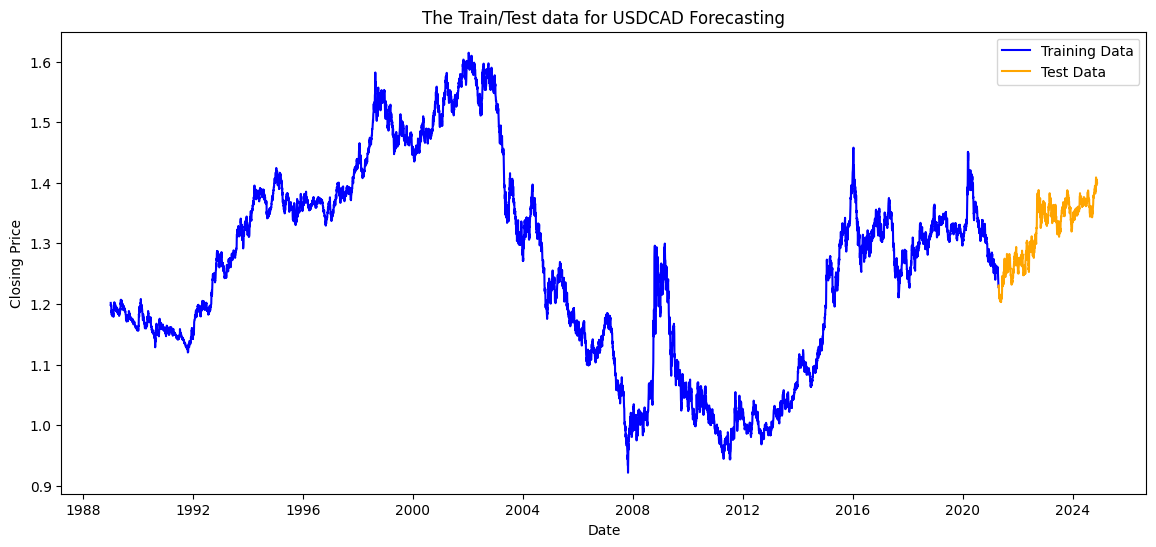

In [47]:
# Plotting the Train/Test Data
Plot_TrainTest(CrncyPair, y_train, y_test)

In [48]:
# Free the memory
#del Complete_Data, Train_Data, Test_Data, Train_Data_Scaled, Test_Data_Scaled, Train_Data_Scaled_Df, Test_Data_Scaled_Df

#### Linear Regression Model

In [49]:
from sklearn.linear_model import LinearRegression

In [50]:
# Instantiate Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

LinearRegression()

In [51]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(model)

R² error on Training Data: 0.99407
R² error on Test Data: 0.93961
Good Model.
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.00972
Mean Squared Error: 0.00015
Root Mean Squared Error: 0.01220
R-squared (R2) score: 0.93961
Future Predictions [1.39837673 1.39266226 1.3944363  1.39480414 1.39589426]


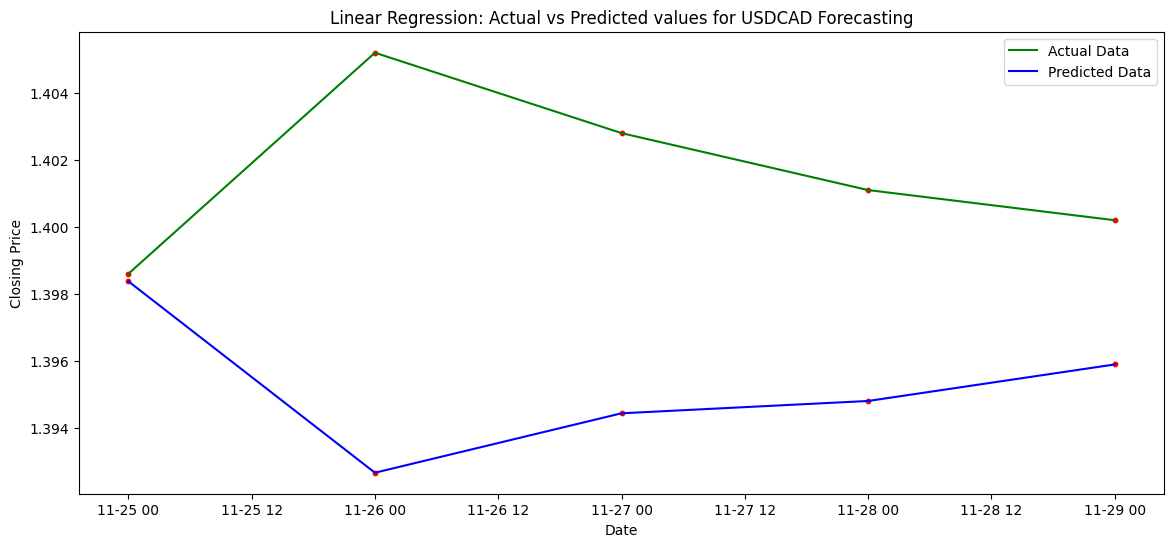

CPU times: user 280 ms, sys: 962 ms, total: 1.24 s
Wall time: 239 ms


In [52]:
%%time
# Make predictions on the testing set
y_pred = model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
LNR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'LNR'
ModelName = 'Linear Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Add to the Dictionary, but first ensure that the list is empty.
ResultsDict[ModelName] = []
if (Comment not in PoorStandard):
    ResultsDict[ModelName].extend(LNR)
    
# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
#del model, y_pred, future_predictions, R2_Train, R2_Test, Comment, ModelCode, ModelName

#### Random Forest Regressor Model

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [54]:
# Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, max_features='log2', random_state=None)
model.fit(X_train, y_train)

RandomForestRegressor(max_features='log2')

In [55]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment  = TestTheModel(model)

R² error on Training Data: 0.99971
R² error on Test Data: 0.91675
Good Model.
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.01150
Mean Squared Error: 0.00021
Root Mean Squared Error: 0.01432
R-squared (R2) score: 0.91675
Future Predictions [1.404316 1.4052   1.403663 1.402531 1.403964]


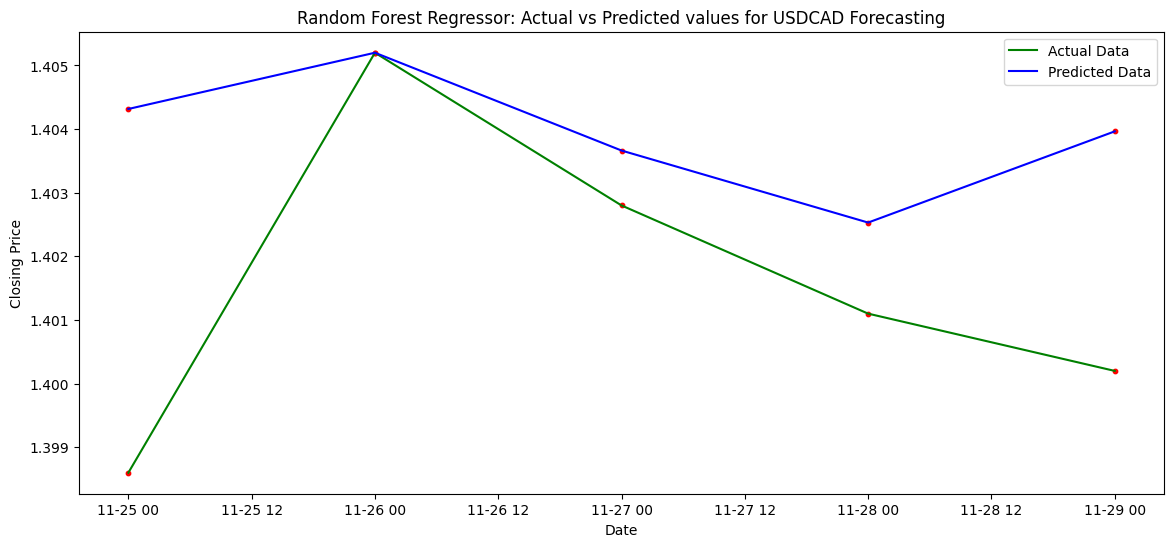

CPU times: user 170 ms, sys: 238 ms, total: 408 ms
Wall time: 162 ms


In [56]:
%%time
# Evaluate the model
y_pred = model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
RFR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'RFR'
ModelName = 'Random Forest Regressor'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Add to the Dictionary, but first ensure that the list is empty.
ResultsDict[ModelName] = []
if (Comment not in PoorStandard):
    ResultsDict[ModelName].extend(RFR)
    
# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
#del model, y_pred, future_predictions, R2_Train, R2_Test, Comment, ModelCode, ModelName

#### XGBoost Model

In [57]:
import xgboost as xgb

In [58]:
# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',   # Use squared error loss for regression
    'max_depth': 2,                    # Maximum depth of trees
    'learning_rate': 0.1,              # Learning rate {0.1}
    'n_estimators': 100,               # Number of boosting rounds (trees)
    'seed': 42                         # Random seed for reproducibility {42}
}

# Instantiate XGBoost regressor
xgb_model = xgb.XGBRegressor(**params)

# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [59]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(xgb_model)

R² error on Training Data: 0.99489
R² error on Test Data: 0.94029
Good Model.
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.00970
Mean Squared Error: 0.00015
Root Mean Squared Error: 0.01213
R-squared (R2) score: 0.94029
Future Predictions [1.4017245 1.3868779 1.3868779 1.3868779 1.3868779]


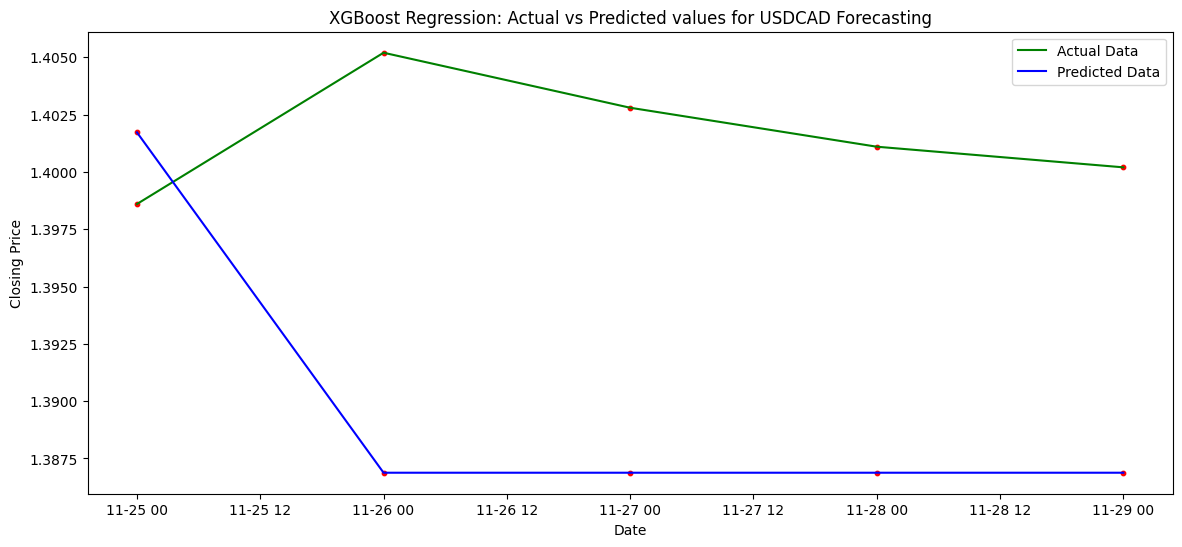

CPU times: user 265 ms, sys: 215 ms, total: 480 ms
Wall time: 154 ms


In [60]:
%%time
# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
XGB = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'XGB'
ModelName = 'XGBoost Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Add to the Dictionary, but first ensure that the list is empty.
ResultsDict[ModelName] = []
if (Comment not in PoorStandard):
    ResultsDict[ModelName].extend(XGB)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
#del xgb_model, y_pred, future_predictions, R2_Train, R2_Test, Comment, ModelCode, ModelName

#### Ridge Regression Model

In [61]:
from sklearn.linear_model import Ridge

In [62]:
# Instantiate and fit the Ridge Regression model
alpha = 0.01  # Regularization strength (hyperparameter to be tuned)
model = Ridge(alpha=alpha)
model.fit(X_train, y_train)

Ridge(alpha=0.01)

In [63]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(model)

R² error on Training Data: 0.99407
R² error on Test Data: 0.94040
Good Model.
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.00966
Mean Squared Error: 0.00015
Root Mean Squared Error: 0.01211
R-squared (R2) score: 0.94040
Future Predictions [1.39840402 1.39274466 1.39440648 1.39432692 1.39576641]


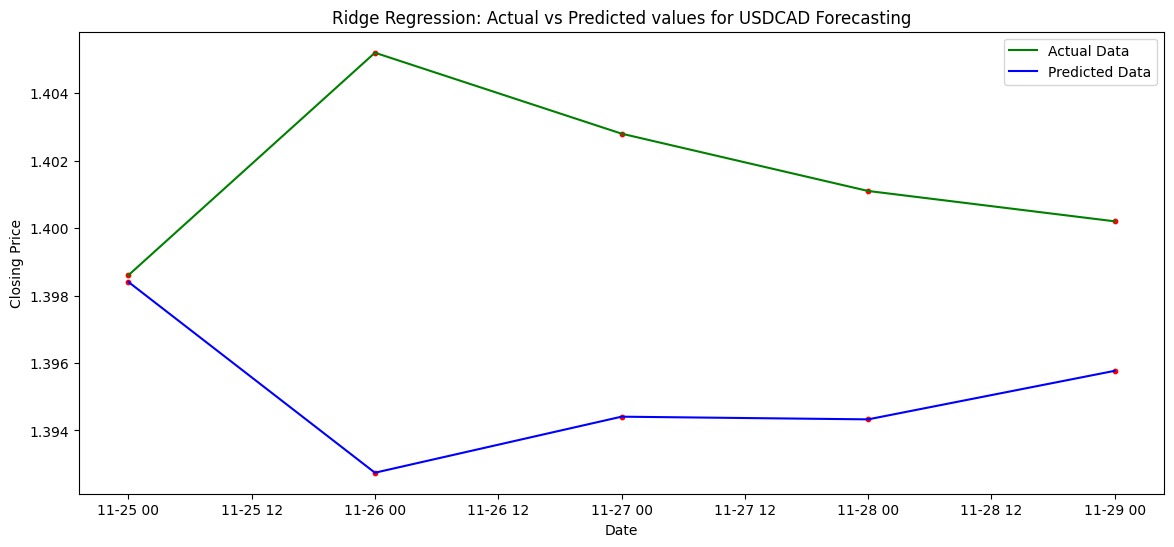

CPU times: user 248 ms, sys: 1.12 s, total: 1.37 s
Wall time: 198 ms


In [64]:
%%time
# Make predictions on the testing set
y_pred = model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
RIR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'RIR'
ModelName = 'Ridge Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Add to the Dictionary, but first ensure that the list is empty.
ResultsDict[ModelName] = []
if (Comment not in PoorStandard):
    ResultsDict[ModelName].extend(RIR)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
#del model, y_pred, future_predictions, R2_Train, R2_Test, Comment, ModelCode, ModelName

#### Lasso Regression Model

In [65]:
from sklearn.linear_model import Lasso

In [66]:
# Instantiate and fit the Lasso Regression model
alpha = 0.00005  # Regularization strength (hyperparameter to be tuned)
model = Lasso(alpha=alpha)
model.fit(X_train, y_train)

Lasso(alpha=5e-05)

In [67]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(model)

R² error on Training Data: 0.99364
R² error on Test Data: 0.94677
Good Model.
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.00913
Mean Squared Error: 0.00013
Root Mean Squared Error: 0.01145
R-squared (R2) score: 0.94677
Future Predictions [1.40385518 1.397357   1.39601067 1.39511761 1.39685691]


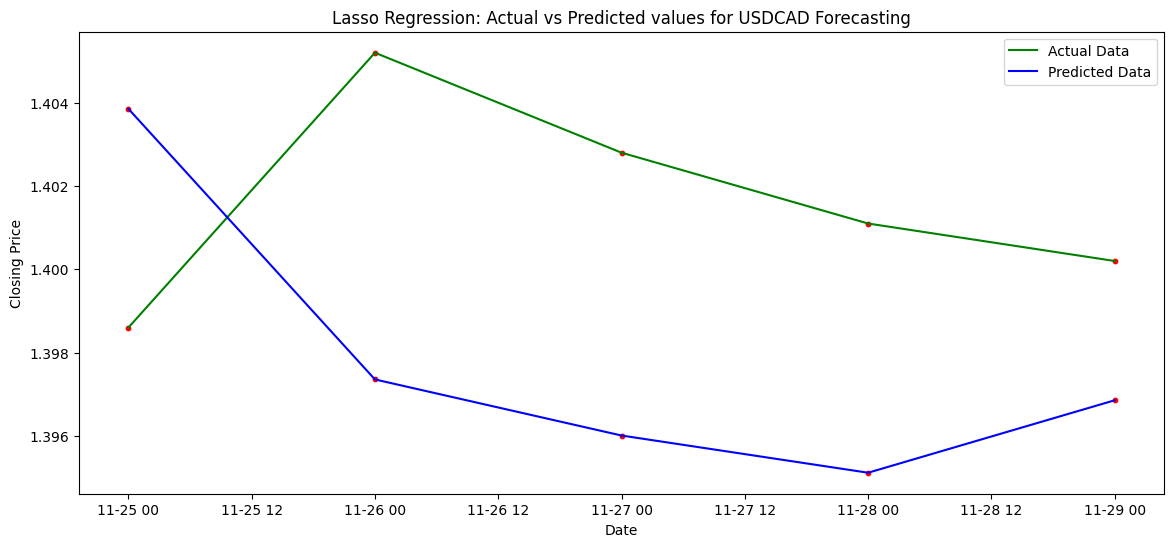

CPU times: user 251 ms, sys: 1.03 s, total: 1.28 s
Wall time: 235 ms


In [68]:
%%time
# Make predictions on the testing set
y_pred = model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
LAR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'LAR'
ModelName = 'Lasso Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Add to the Dictionary, but first ensure that the list is empty.
ResultsDict[ModelName] = []
if (Comment not in PoorStandard):
    ResultsDict[ModelName].extend(LAR)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
#del model, y_pred, future_predictions, R2_Train, R2_Test, Comment, ModelCode, ModelName

#### Support Vector Regression (SVR) Model

In [69]:
from sklearn.svm import SVR

In [70]:
svr_model = SVR(kernel='rbf', C=0.00001, epsilon=0.1)
svr_model.fit(X_train, y_train)

SVR(C=1e-05)

In [71]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(svr_model)

R² error on Training Data: 0.11261
R² error on Test Data: -1.85414
Very Bad Model.


Mean Absolute Error: 0.07222
Mean Squared Error: 0.00703
Root Mean Squared Error: 0.08384
R-squared (R2) score: -1.85414
Future Predictions [1.25419908 1.25416759 1.25416193 1.25415825 1.25417366]


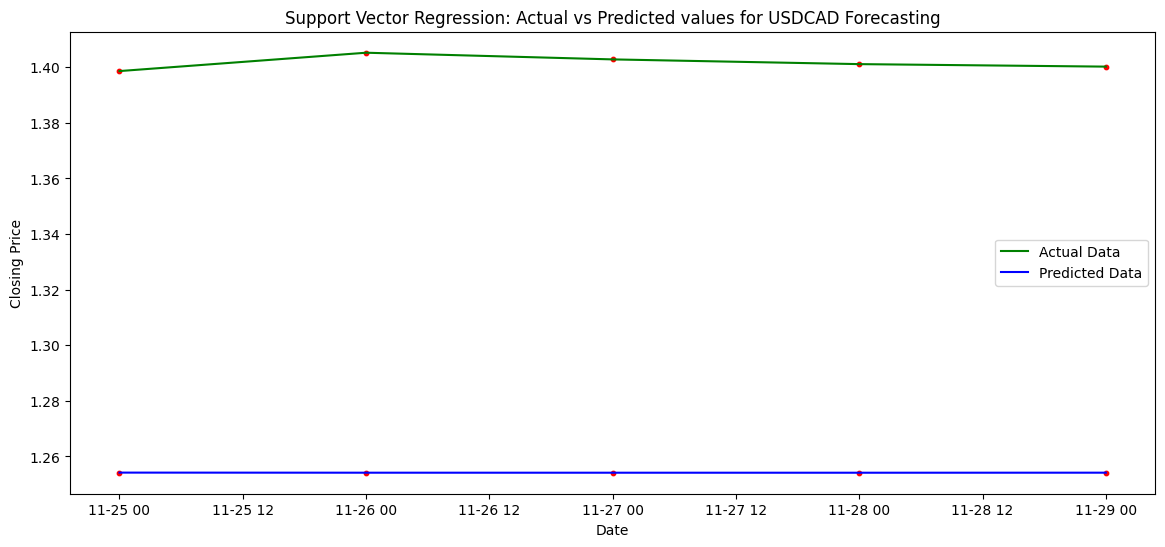

CPU times: user 379 ms, sys: 222 ms, total: 601 ms
Wall time: 357 ms


In [72]:
%%time
# Make predictions on the testing set
y_pred = svr_model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
SVR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'SVR'
ModelName = 'Support Vector Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Add to the Dictionary, but first ensure that the list is empty.
ResultsDict[ModelName] = []
if (Comment not in PoorStandard):
    ResultsDict[ModelName].extend(SVR)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
#del svr_model, y_pred, future_predictions, R2_Train, R2_Test, Comment, ModelCode, ModelName

#### Bayesian Ridge Regression Model

In [73]:
from sklearn.linear_model import BayesianRidge

In [74]:
Baye_model = BayesianRidge()
Baye_model.fit(X_train, y_train)

BayesianRidge()

In [75]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(Baye_model)

R² error on Training Data: 0.99407
R² error on Test Data: 0.94002
Good Model.
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.00969
Mean Squared Error: 0.00015
Root Mean Squared Error: 0.01215
R-squared (R2) score: 0.94002
Future Predictions [1.39838657 1.39269131 1.39441293 1.39456728 1.39582184]


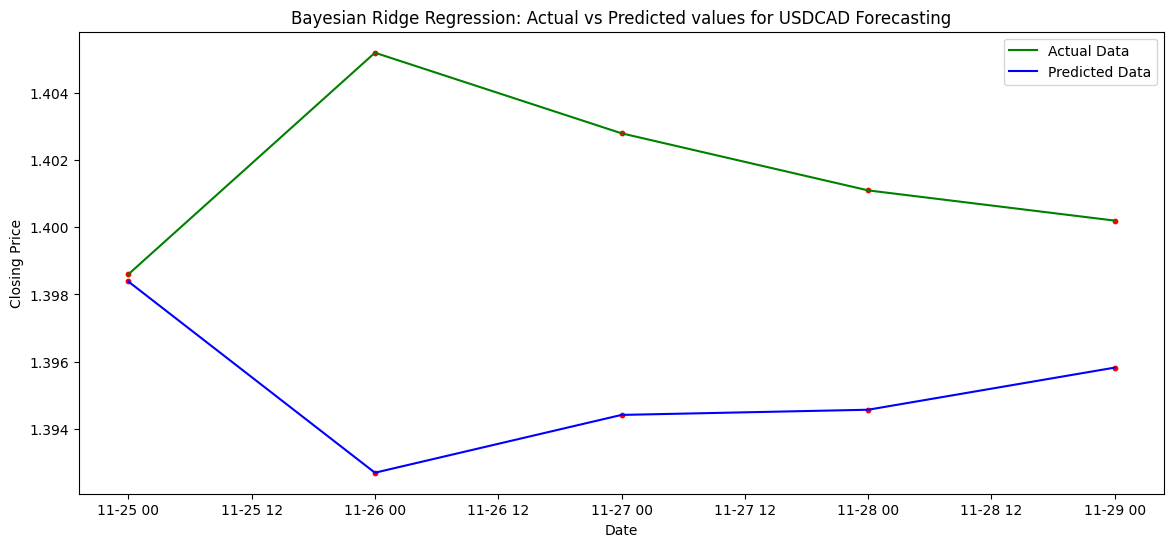

CPU times: user 365 ms, sys: 1.16 s, total: 1.53 s
Wall time: 288 ms


In [76]:
%%time
# Make predictions on the testing set
y_pred = Baye_model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
BRR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'BRR'
ModelName = 'Bayesian Ridge Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Add to the Dictionary, but first ensure that the list is empty.
ResultsDict[ModelName] = []
if (Comment not in PoorStandard):
    ResultsDict[ModelName].extend(BRR)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
#del Baye_model, y_pred, future_predictions, R2_Train, R2_Test, Comment, ModelCode, ModelName

#### AdaBoost Regression Model

In [77]:
from sklearn.ensemble import AdaBoostRegressor

In [78]:
AdaB_model = AdaBoostRegressor(n_estimators=101, random_state=None)
AdaB_model.fit(X_train, y_train)

AdaBoostRegressor(n_estimators=101)

In [79]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(AdaB_model)

R² error on Training Data: 0.99048
R² error on Test Data: 0.89071
Good Model.
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.01287
Mean Squared Error: 0.00027
Root Mean Squared Error: 0.01641
R-squared (R2) score: 0.89071
Future Predictions [1.40879753 1.40163238 1.40163238 1.40163238 1.40163238]


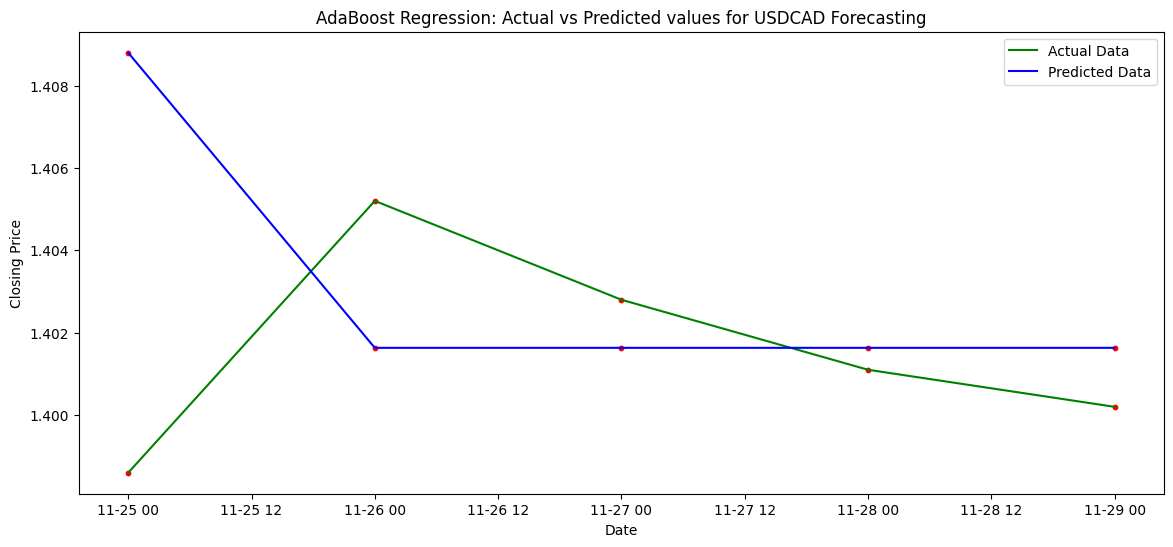

CPU times: user 165 ms, sys: 231 ms, total: 396 ms
Wall time: 150 ms


In [80]:
%%time
# Make predictions on the testing set
y_pred = AdaB_model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
ABR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'ABR'
ModelName = 'AdaBoost Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Add to the Dictionary, but first ensure that the list is empty.
ResultsDict[ModelName] = []
if (Comment not in PoorStandard):
    ResultsDict[ModelName].extend(ABR)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
#del AdaB_model, y_pred, future_predictions, R2_Train, R2_Test, Comment, ModelCode, ModelName

## Summary of the model results

In [81]:
Models_Compare

,ModelName,ModelCode,MAE,MSE,RMSE,R²_Train,R²_Test,Comment
0,Linear Regression,LNR,0.009720,0.000149,0.012195,0.994074,0.939609,Good Model.
1,Random Forest Regressor,RFR,0.011502,0.000205,0.014318,0.999712,0.916747,Good Model.
2,XGBoost Regression,XGB,0.009695,0.000147,0.012126,0.994891,0.940292,Good Model.
3,Ridge Regression,RIR,0.009659,0.000147,0.012115,0.994068,0.940399,Good Model.
4,Lasso Regression,LAR,0.009127,0.000131,0.011449,0.993642,0.946768,Good Model.
5,Support Vector Regression,SVR,0.072223,0.007029,0.083837,0.112613,-1.854144,Very Bad Model.
6,Bayesian Ridge Regression,BRR,0.009688,0.000148,0.012153,0.994073,0.940020,Good Model.
7,AdaBoost Regression,ABR,0.012868,0.000269,0.016405,0.990485,0.890714,Good Model.


In [82]:
Models_Compare[['ModelName','MAE','MSE','RMSE','R²_Train','R²_Test', 'Comment']]

,ModelName,MAE,MSE,RMSE,R²_Train,R²_Test,Comment
0,Linear Regression,0.009720,0.000149,0.012195,0.994074,0.939609,Good Model.
1,Random Forest Regressor,0.011502,0.000205,0.014318,0.999712,0.916747,Good Model.
2,XGBoost Regression,0.009695,0.000147,0.012126,0.994891,0.940292,Good Model.
3,Ridge Regression,0.009659,0.000147,0.012115,0.994068,0.940399,Good Model.
4,Lasso Regression,0.009127,0.000131,0.011449,0.993642,0.946768,Good Model.
5,Support Vector Regression,0.072223,0.007029,0.083837,0.112613,-1.854144,Very Bad Model.
6,Bayesian Ridge Regression,0.009688,0.000148,0.012153,0.994073,0.940020,Good Model.
7,AdaBoost Regression,0.012868,0.000269,0.016405,0.990485,0.890714,Good Model.


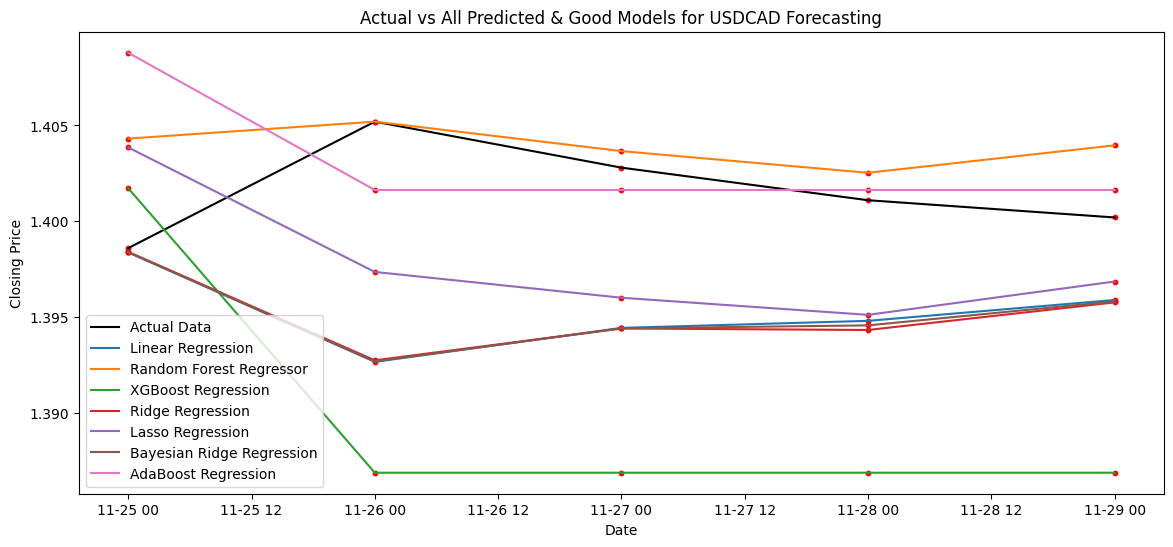

In [83]:
# Plot Actual vs Predicted prices
Future_Dates = pd.date_range(start=MaxDate+timedelta(days=1), periods=PredDays, freq="B")

plt.figure(figsize=(14, 6))

# Plot the Actual Values.
plt.plot(Future_Dates, ActualValues, label='Actual Data', color='black')
plt.scatter(Future_Dates, ActualValues, s=10, color='red')

# Plot the Predicted Values.
for Key, Values in ResultsDict.items():
    if (len(Values) != 0):      # The Bad Models will be empty.
        plt.plot(Future_Dates, Values, label=Key)
        plt.scatter(Future_Dates, Values, s=10, color='red')
    
plt.title('Actual vs All Predicted & Good Models for ' + CrncyPair + ' Forecasting')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [84]:
ActualValues

array([1.3986, 1.4052, 1.4028, 1.4011, 1.4002])

In [85]:
# Free the Memory
#del FxPair_Data, X, y, X_train, X_test, y_train, y_test

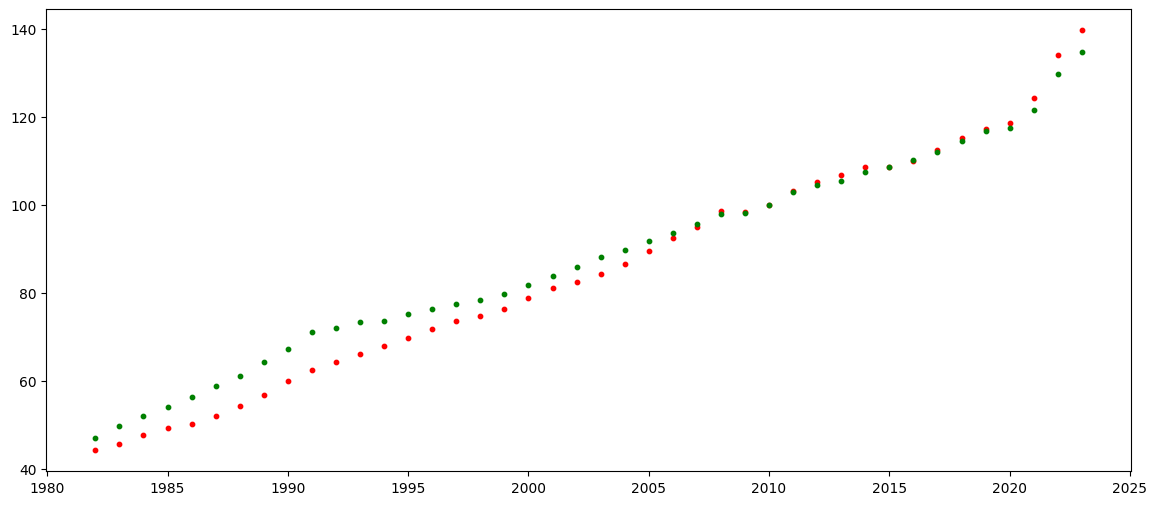

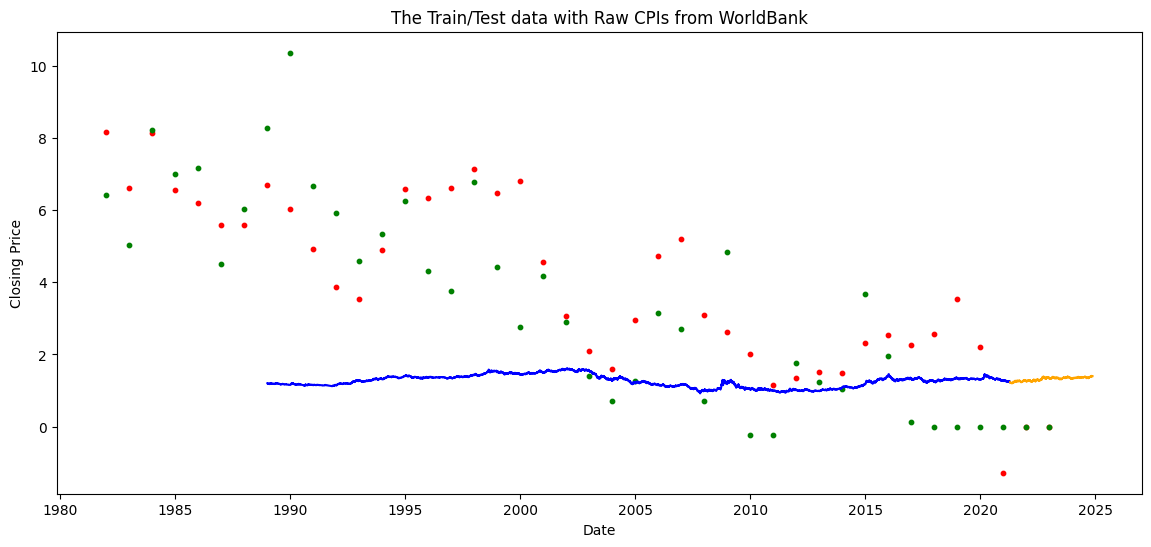

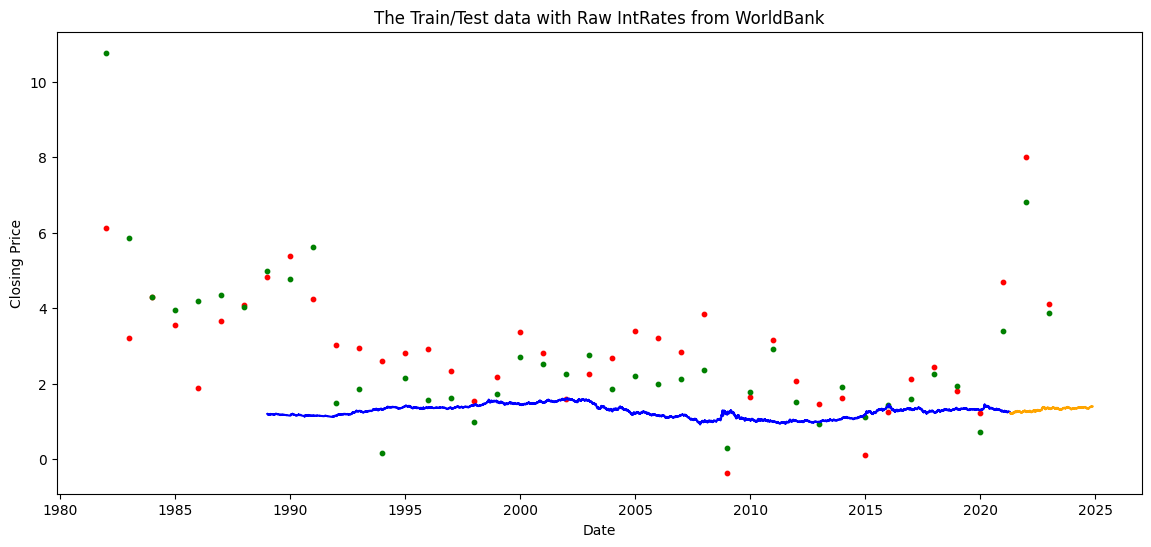

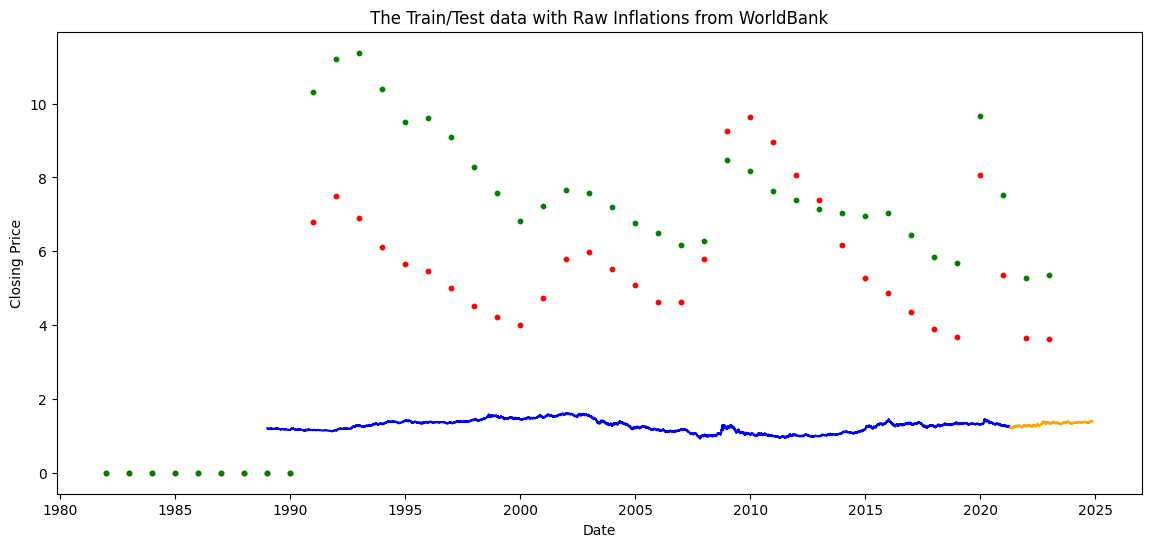

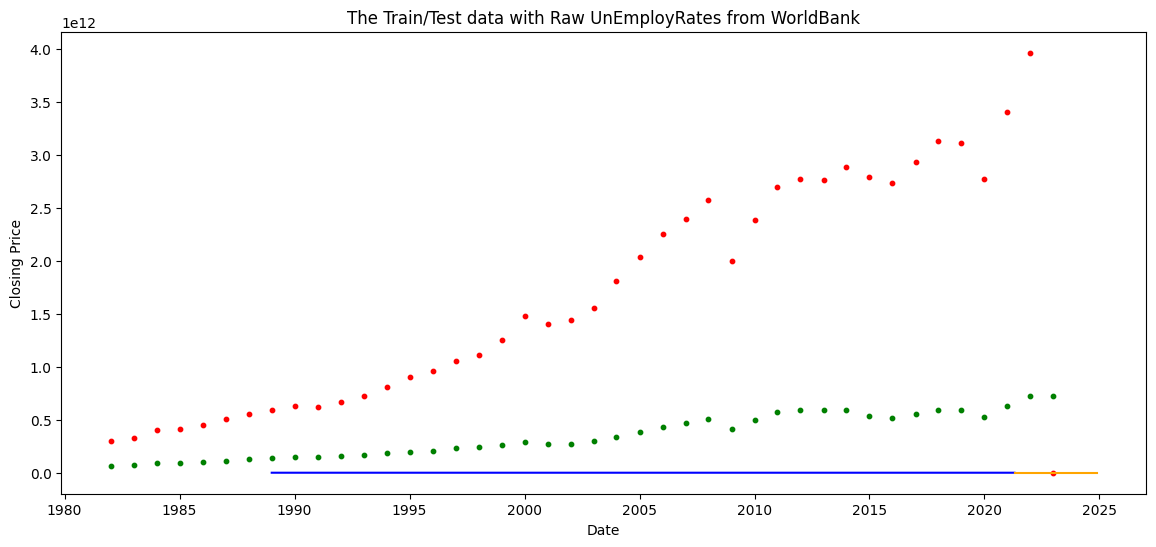

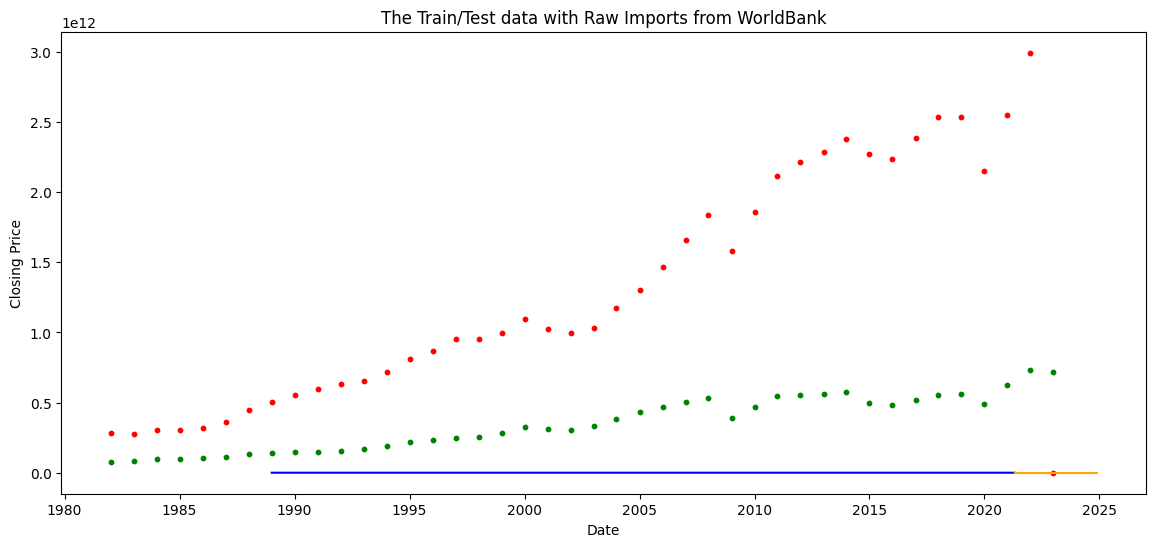

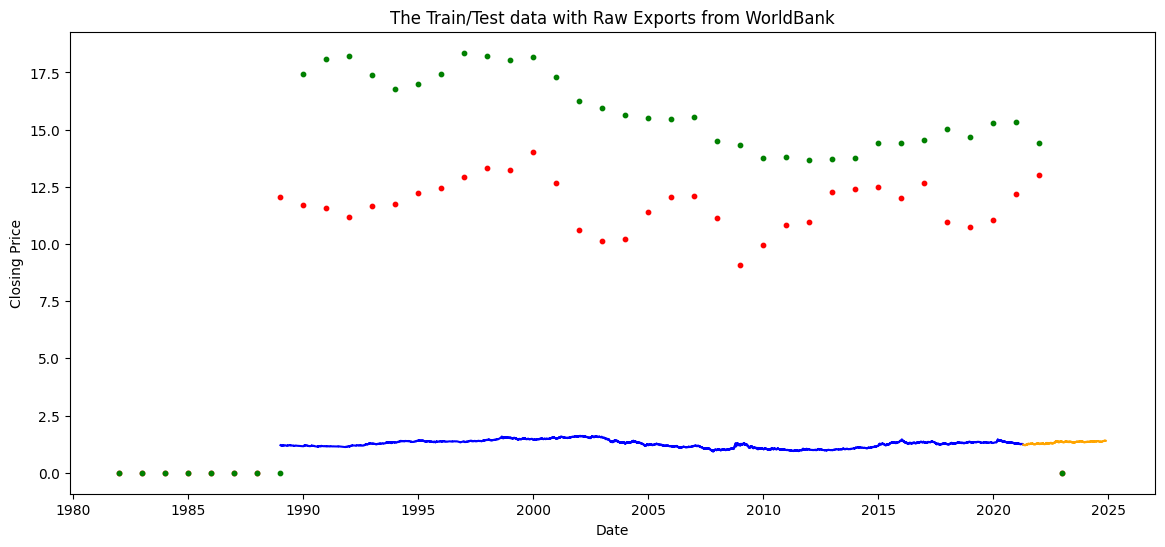

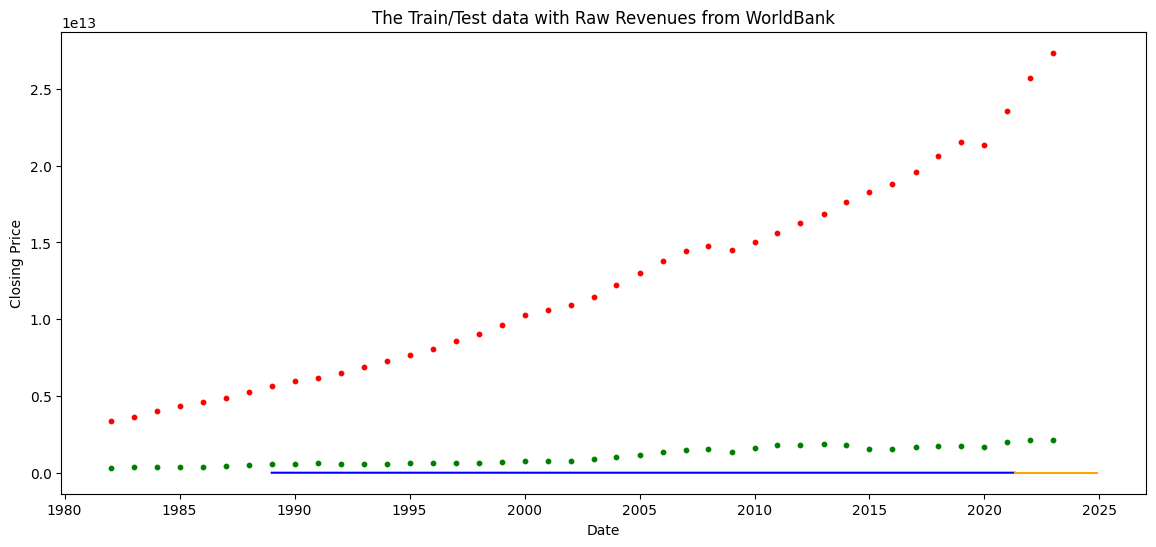

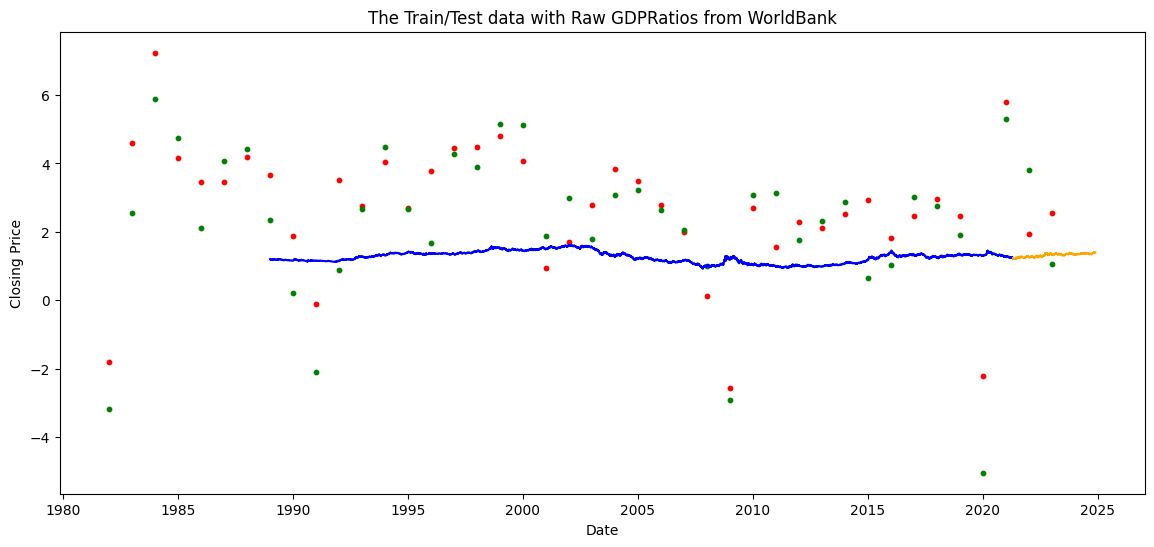

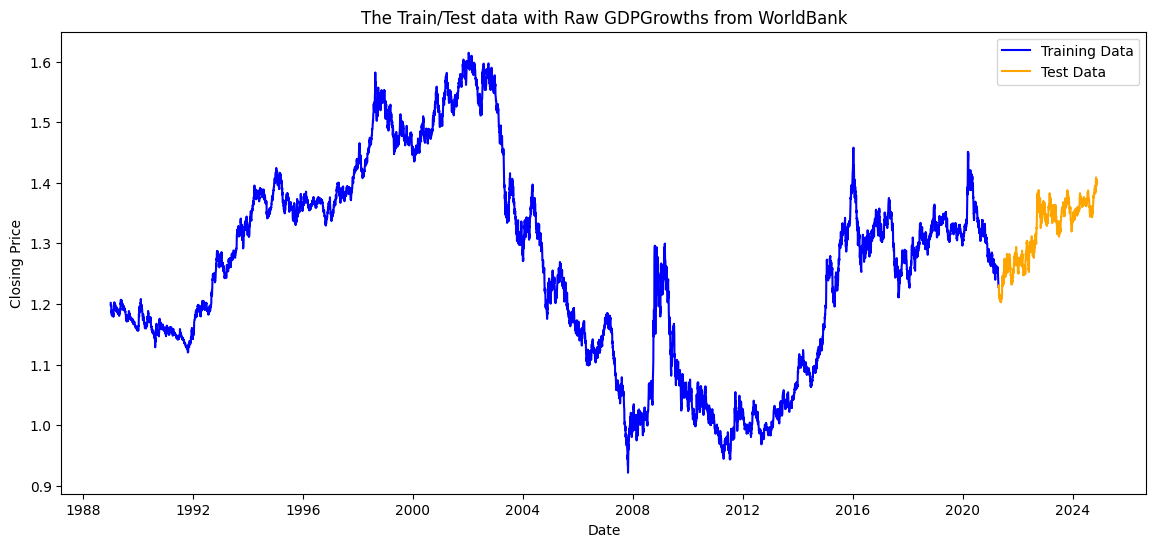

In [86]:
# Plot the Raw MacroEconomic Data
#Plot_RawMacroEcons('FRED', MacroEconomic_Series_USA, CrncyPair, y_train, y_test, RawMacroEcons_FRED)
Plot_RawMacroEcons('WorldBank', MacroEconomic_Series_WorldBank, CrncyPair, y_train, y_test, RawMacroEcons_WorldBank)